# Differential Expression (DE) Analysis

## Load `msmu` and `MuData` to be used.

Use the `MuData` object as `mdata` processed in tutorials [DDA-TMT](dda-tmt.ipynb), [DDA-LFQ](dda-lfq.ipynb), or [DIA-LFQ](dia-lfq.ipynb). It should have a modality to test, in this case, `protein`.

If `MuData` were saved locally, provide the path to the file in `mm.read_h5mu()` function.


In [ ]:
import msmu as mm

# Set default renderer to static image for better compatibility
import plotly.io as pio

pio.renderers.default = "png"

# mdata = mm.read_h5mu("dda_lfq_PXD012986.h5mu")  # DDA-LFQ example data

mdata = mm.read_h5mu("/Users/wook/Desktop/bertis/test/dda_lfq_PXD012986.h5mu")  # DDA-LFQ example data

## Run DE analysis

Permutation-based DE analysis basically provided by `mm.tl.run_de()` function. Here, we will compare two conditions, `G1` and `G2`, in the `condition` column of `mdata.obs`.

`modality` specifies which modality to perform DE analysis on. `category` indicates the column name in `mdata.obs` that contains the group labels.

`ctrl` and `expr` define the control and experimental groups, respectively.

`stat_method` allows you to choose the statistical test method, such as `welch`, `student`, or `wilcoxon`.

`measure` defines the measure of central tendency used for calculating fold-change, either `median` or `mean`.

`min_pct` sets the minimum fraction of non-missing values required in at least one group for a feature to be considered in the analysis.

`n_resamples` sets the number of resampling iterations for permutation testing; if set to `None`, simple parametric p-values are computed.

`fdr` specifies the multiple testing correction method, which can be `empirical`, `bh` (Benjamini-Hochberg), or `None`.

`log_transformed` indicates whether the data is log-transformed.


More explanation for `run_de()` can be found in the [DE Analysis](../../how-it-works/dea/) documentation and the [`mm.tl.run_de()`](../../reference/tl/run_de/) API reference.

In an example below, we assign 1000 resamples, but only 20 permutations are performed because each group has 3 samples and 3 by 3 gives 20 combinations, which is `exact` test.


In [4]:
de_res = mm.tl.run_de(
    mdata,
    modality="protein",
    category="condition",  # category in .obs to define groups
    ctrl="G1",             # control group
    expr="G2",             # experimental group
    stat_method="welch",   # statistical test method: "welch", "student", "wilcoxon", default "welch"
    measure="median",      # measure of central tendancy for calculating fold-change: "median", "mean", default "median"
    min_pct=0.5,           # minimum fraction of non-missing values in at least one group, default 0.5
    fdr="empirical",       # multiple testing correction method: "empirical", "bh", or None, default "empirical"
    n_resamples=1000,      # by default, 1000 resamples; if None, simple parametric p-values are computed
    log_transformed=True,  # whether data is log-transformed, default True
)

Running Permutations: 100%|██████████| 20/20 [00:00<00:00, 644.08it/s]


## Explore DE results

Result is stored in `DeaResult` object. And the object provides few methods to explore the results. This object provides `to_df()` method to convert the results into a pandas DataFrame for further exploration. And `plot_volcano()` method to visualize the results as a volcano plot.


In [5]:
de_res

DeaResult(stat_method='welch', ctrl='G1', expr='G2', features=array(['A0A023T778,G3UZW7,P61327,Q9CQL1',
       'A0A068CB13,A2QBC3,B2CNX8,B2CNX9,G3XSF9,I6VCW8,P13006',
       'A0A087WNT1,A0A087WPE4,A0A087WQE6,P83940', ..., 'Q9Z2U0', 'Q9Z2X1',
       'Q9Z315'], shape=(1463,), dtype=object), repr_ctrl=array([4.525732 , 4.64865  , 4.667814 , ..., 4.7323623, 4.678545 ,
       4.4805293], shape=(1463,), dtype=float32), repr_expr=array([4.529395 , 4.844484 , 4.662926 , ..., 4.720763 , 4.6980944,
       4.481769 ], shape=(1463,), dtype=float32), pct_ctrl=array([100., 100., 100., ..., 100., 100., 100.], shape=(1463,)), pct_expr=array([100., 100., 100., ..., 100., 100., 100.], shape=(1463,)), log2fc=array([ 0.00366306,  0.19583368, -0.00488758, ..., -0.01159906,
        0.01954937,  0.00123978], shape=(1463,), dtype=float32))

In [6]:
de_res.to_df().head()

,features,repr_ctrl,repr_expr,pct_ctrl,pct_expr,log2fc,p_value,q_value
0,"A0A023T778,G3UZW7,P61327,Q9CQL1",4.525732,4.529395,100.0,100.0,0.003663,0.444217,0.820750
1,"A0A068CB13,A2QBC3,B2CNX8,B2CNX9,G3XSF9,I6VCW8,...",4.648650,4.844484,100.0,100.0,0.195834,0.000104,0.067888
2,"A0A087WNT1,A0A087WPE4,A0A087WQE6,P83940",4.667814,4.662926,100.0,100.0,-0.004888,0.972412,0.902238
3,"A0A087WNT3,A0A087WNU9,A0A087WP64,A0A087WPE6,A0...",NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,"A0A087WNY6,A0A087WQA5,A0A087WQX8,A0A087WRP4,A0...",4.691034,4.688916,100.0,100.0,-0.002118,0.818561,0.879705


After permutation test, guidance for log2FC threshold at 5% (or 1%) on two-sided tails of null distribution from permutations is also provided.


In [7]:
print(f"Log2FC threshold at 5%: {de_res.fc_pct_5}")

Log2FC threshold at 5%: 0.02


To visualize the DE results, `plot_volcano()` method is available. Log2FC and p-value thresholds can be set manually or automatically using the `fc_pct_5` attribute from the result object and p-value of `0.05`.

Top significant features can be labelled using `label_top` parameter (sorted by log2FC).


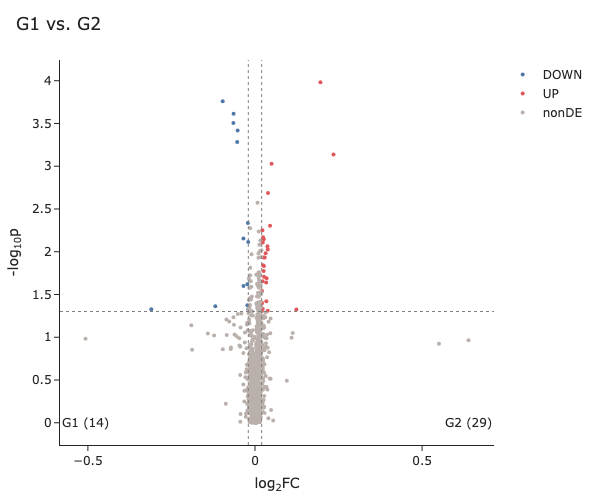

In [8]:
de_res.plot_volcano()

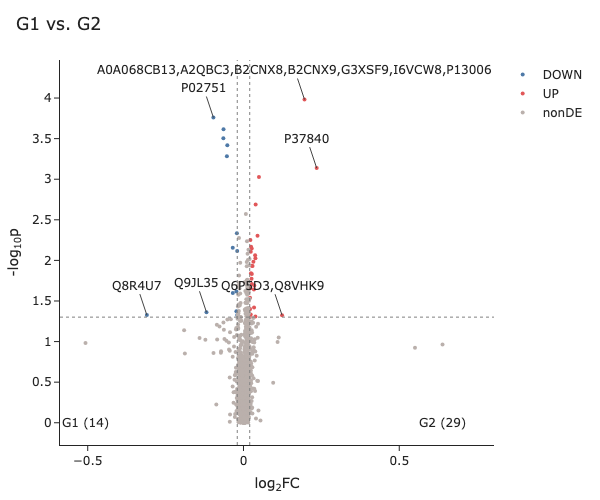

In [9]:
de_res.plot_volcano(label_top=3)